# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1040s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1380, 32, 20, 3)
(1380, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
345/345 [==============================] - 4s 8ms/step - loss: 2.1033 - accuracy: 0.3441
Epoch 2/500
345/345 [==============================] - 3s 7ms/step - loss: 1.2150 - accuracy: 0.6125
Epoch 3/500
345/345 [==============================] - 3s 8ms/step - loss: 0.8802 - accuracy: 0.7323
Epoch 4/500
345/345 [==============================] - 3s 8ms/step - loss: 0.7513 - accuracy: 0.7510: 0s - loss: 0.7506 - accuracy
Epoch 5/500
345/345 [==============================] - 3s 8ms/step - loss: 0.6965 - accuracy: 0.8060: 0s - loss: 0.7012 - accu
Epoch 6/500
345/345 [==============================] - 3s 8ms/step - loss: 0.6064 - accuracy: 0.8140
Epoch 7/500
345/345 [==============================] - 3s 7ms/step - loss: 0.5986 - accuracy: 0.8087
Epoch 8/500
345/345 [==============================] - 3s 8ms/step - loss: 0.5223 - accuracy: 0.8369
Epoch 9/500
345/345 [==============================] - 3s 7ms/step - loss: 0.3897 - accuracy: 0.8711
Epoch 10/500
345/345 [=============

345/345 [==============================] - 3s 8ms/step - loss: 0.0889 - accuracy: 0.9708
Epoch 81/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0670 - accuracy: 0.9794
Epoch 82/500
345/345 [==============================] - 3s 8ms/step - loss: 0.1332 - accuracy: 0.9693
Epoch 83/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0623 - accuracy: 0.9786
Epoch 84/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0708 - accuracy: 0.9845
Epoch 85/500
345/345 [==============================] - 3s 8ms/step - loss: 0.1130 - accuracy: 0.9759
Epoch 86/500
345/345 [==============================] - 3s 9ms/step - loss: 0.0953 - accuracy: 0.9728: 0s - loss:
Epoch 87/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0935 - accuracy: 0.9776
Epoch 88/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0695 - accuracy: 0.9846
Epoch 89/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0778 

345/345 [==============================] - 3s 7ms/step - loss: 0.0521 - accuracy: 0.9848
Epoch 159/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0716 - accuracy: 0.9805
Epoch 160/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0409 - accuracy: 0.9828
Epoch 161/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0228 - accuracy: 0.9959
Epoch 162/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0602 - accuracy: 0.9860: 0s - loss: 0.0612 
Epoch 163/500
345/345 [==============================] - 3s 8ms/step - loss: 0.1067 - accuracy: 0.9778
Epoch 164/500
345/345 [==============================] - 3s 7ms/step - loss: 0.0248 - accuracy: 0.9949
Epoch 165/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0503 - accuracy: 0.9826
Epoch 166/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0287 - accuracy: 0.9900
Epoch 167/500
345/345 [==============================] - 3s 8ms/ste

345/345 [==============================] - 3s 8ms/step - loss: 0.0194 - accuracy: 0.9928
Epoch 237/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0272 - accuracy: 0.9905
Epoch 238/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0421 - accuracy: 0.9895
Epoch 239/500
345/345 [==============================] - 3s 9ms/step - loss: 0.0393 - accuracy: 0.9909: 0s - loss: 0
Epoch 240/500
345/345 [==============================] - 3s 9ms/step - loss: 0.0214 - accuracy: 0.9940
Epoch 241/500
345/345 [==============================] - 3s 9ms/step - loss: 0.0333 - accuracy: 0.9910
Epoch 242/500
345/345 [==============================] - 3s 9ms/step - loss: 0.0514 - accuracy: 0.9898
Epoch 243/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0096 - accuracy: 0.9968
Epoch 244/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0261 - accuracy: 0.9968
Epoch 245/500
345/345 [==============================] - 3s 8ms/step - lo

345/345 [==============================] - 3s 8ms/step - loss: 0.0235 - accuracy: 0.9935
Epoch 316/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0157 - accuracy: 0.9945: 0s - loss: 0.0153 - accuracy: 
Epoch 317/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0416 - accuracy: 0.9942
Epoch 318/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0612 - accuracy: 0.9930
Epoch 319/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0317 - accuracy: 0.9916
Epoch 320/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0382 - accuracy: 0.9889
Epoch 321/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0217 - accuracy: 0.9928
Epoch 322/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0075 - accuracy: 0.9972
Epoch 323/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0039 - accuracy: 0.9972
Epoch 324/500
345/345 [==============================] 

345/345 [==============================] - 3s 8ms/step - loss: 0.0284 - accuracy: 0.9915
Epoch 394/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0234 - accuracy: 0.9901
Epoch 395/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0454 - accuracy: 0.9897
Epoch 396/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0177 - accuracy: 0.9961: 0s - loss: 0
Epoch 397/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0157 - accuracy: 0.9953
Epoch 398/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0099 - accuracy: 0.9959
Epoch 399/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0353 - accuracy: 0.9910: 
Epoch 400/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0185 - accuracy: 0.9951
Epoch 401/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0354 - accuracy: 0.9898
Epoch 402/500
345/345 [==============================] - 3s 8ms/step - 

345/345 [==============================] - 3s 8ms/step - loss: 0.0060 - accuracy: 0.9997
Epoch 472/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0257 - accuracy: 0.9961
Epoch 473/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0275 - accuracy: 0.9961
Epoch 474/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0095 - accuracy: 0.9980
Epoch 475/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0081 - accuracy: 0.9981
Epoch 476/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0060 - accuracy: 0.9983
Epoch 477/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0058 - accuracy: 0.9974
Epoch 478/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0297 - accuracy: 0.9927
Epoch 479/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0244 - accuracy: 0.9948
Epoch 480/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0433 - a

### Learing result
 
* Visualization of the training and validation results

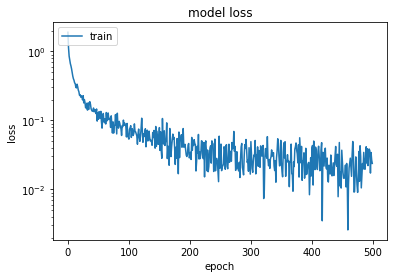

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

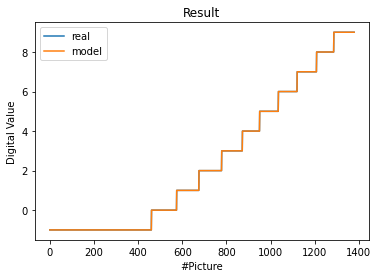

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp8mgqidrv\assets


766432

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpdnb6vsd2\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpdnb6vsd2\assets


203200

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.